# Real overlap function
Created 26/05/2024

Objectives:
* Try different overlap functions to circumvent complex -> real issue.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [10]:
psi = loaded_data_non_triv_proj_rep[0]

In [11]:
from collections import Counter

In [12]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [13]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [14]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [15]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [16]:
q2 = q1.copy(deep=True)

symmetry_sites = list(range(60, 60+80, 2))
for i in symmetry_sites:

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [17]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = quimb_psi.copy()
    q_bottom.reindex(index_mapping, inplace=True)

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [18]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

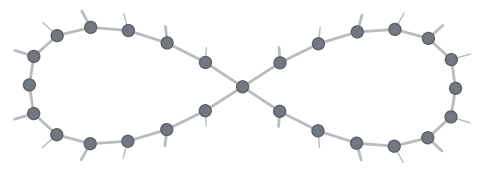

In [19]:
problem_rdm.draw()

## Initial mpos

In [20]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80

In [116]:
ml = qtn.MPO_rand(
    num_boundary_sites,
    5,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
    dtype='complex',
    tags='left_mpo'
)

In [117]:
mr = qtn.MPO_rand(
    num_boundary_sites,
    3,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(
        left_most_symmetry_site + num_symmetry_sites,
        left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
    )),
    dtype='complex',
    tags='right_mpo'
)

In [118]:
mpo = (ml & mr)

## Optimisation functions

In [119]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [120]:
abs(1+1j)

1.4142135623730951

In [121]:
from jax import numpy as jnp

In [122]:
z = 1 + 1j

In [123]:
jnp.sum(jnp.conjugate(z)).astype('float32')

Array(1., dtype=float32)

In [124]:
jnp.sum(jnp.conjugate(z)).astype('float32')._value

array(1., dtype=float32)

In [125]:
jnp.sum(jnp.conjugate(z)).astype('float32')

Array(1., dtype=float32)

In [126]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared))

    loss = (c_abs - 1)**2

    return loss

In [127]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [128]:
total_physical_dim = 2**9

In [129]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [130]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [202]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [132]:
unitarity_tn(ml, total_physical_dim)

510.0106833089041

In [139]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [134]:
overall_loss_function(
    mpo,
    problem_rdm,
    total_physical_dim
)

Array(1021.0219, dtype=float32)

# Runs
## 1

In [140]:
loss_data=list()

In [141]:
total_physical_dim = 2**9

In [142]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [143]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+nan [best: +1021.021911621094] : : 1001it [00:03, 288.93it/s]                                                                                                                                              


In [144]:
len(loss_data)

1

But lose loss data for some reason...?

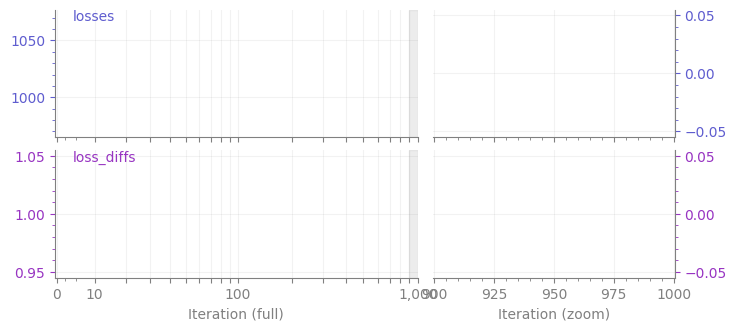

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [145]:
optmzr.plot()

In [146]:
ml, mr = split_mpo_pair(mpo_opt)

In [147]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(nan, dtype=float32), (nan+nanj), (nan+nanj))

## 2

In [148]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = c_abs_squared.astype('float32')
    #c_abs = (jnp.sqrt(c_abs_squared))

    loss = (c_abs_squared - 1)**2

    return loss

In [149]:
loss_data=list()

In [150]:
total_physical_dim = 2**9

In [151]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [152]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+1.172424316406 [best: +1.172424316406] : : 1001it [00:03, 333.63it/s]                                                                                                                                      


In [153]:
len(loss_data)

1

But lose loss data for some reason...?

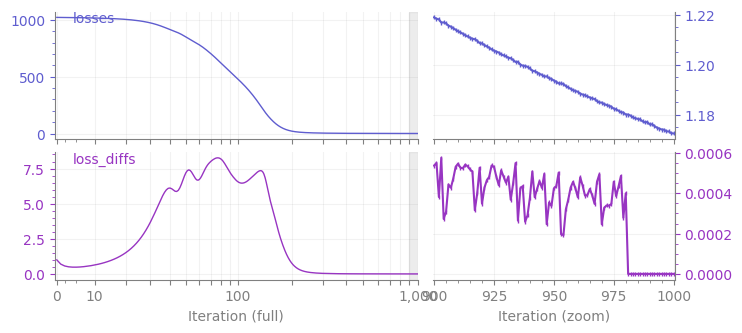

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [154]:
optmzr.plot()

In [155]:
ml, mr = split_mpo_pair(mpo_opt)

In [156]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(1., dtype=float32),
 (0.080169677734375-2.407258330094919e-05j),
 (0.091949462890625-1.8711394659476355e-05j))

## 3

In [157]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs = jnp.abs(c)

    return -c_abs

In [158]:
loss_data=list()

In [159]:
total_physical_dim = 2**9

In [160]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [161]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.172424316406 [best: +0.172424316406] : : 1001it [00:02, 338.50it/s]                                                                                                                                      


In [162]:
len(loss_data)

1

But lose loss data for some reason...?

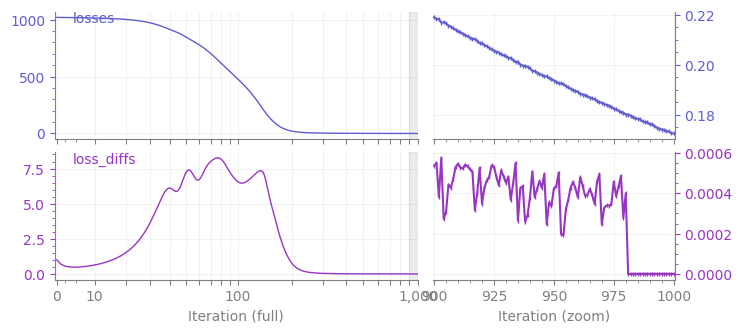

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [163]:
optmzr.plot()

In [164]:
ml, mr = split_mpo_pair(mpo_opt)

In [165]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(-1.1233511e-31, dtype=float32),
 (0.080169677734375-2.407258330094919e-05j),
 (0.091949462890625-1.8711394659476355e-05j))

## 4

In [166]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs = jnp.abs(c)

    return -c_abs

In [167]:
loss_data=list()

In [168]:
total_physical_dim = 2**9

In [169]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1000,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [170]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.172424316406 [best: +0.172424316406] : : 1001it [00:03, 307.52it/s]                                                                                                                                      


In [171]:
len(loss_data)

1

But lose loss data for some reason...?

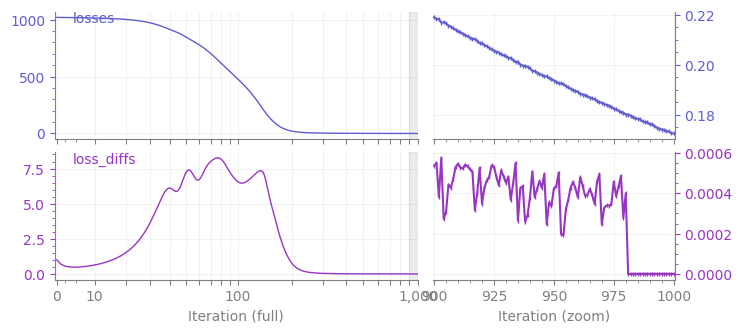

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [172]:
optmzr.plot()

In [173]:
ml, mr = split_mpo_pair(mpo_opt)

In [174]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(-1.1233511e-31, dtype=float32),
 (0.080169677734375-2.407258330094919e-05j),
 (0.091949462890625-1.8711394659476355e-05j))

## 5

In [175]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared))

    loss = (c_abs - 1)**2

    return loss

In [176]:
loss_data=list()

In [177]:
total_physical_dim = 2**9

In [178]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [179]:
mpo_opt = optmzr.optimize(
    1000,
    learning_rate=0.0001,
    beta1=0.3,
    beta2=0.3,
)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+nan [best: +1021.021911621094] : : 1001it [00:03, 304.05it/s]                                                                                                                                              


In [180]:
len(loss_data)

1

But lose loss data for some reason...?

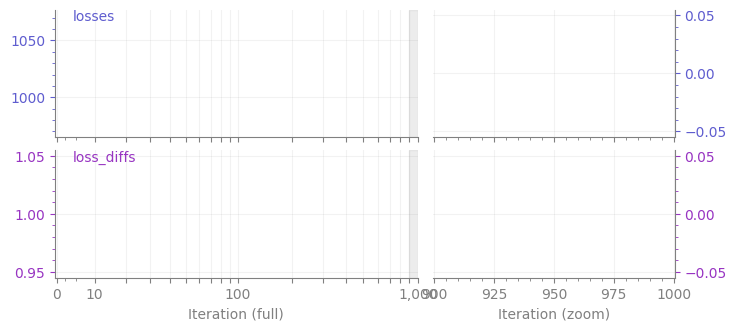

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [181]:
optmzr.plot()

In [182]:
ml, mr = split_mpo_pair(mpo_opt)

In [183]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(nan+nanj, dtype=complex64), (nan+nanj), (nan+nanj))

## 6

In [184]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared))

    loss = (c_abs - 1)**2

    return loss

In [185]:
loss_data=list()

In [186]:
total_physical_dim = 2**9

In [187]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [188]:
mpo_opt = optmzr.optimize(
    1000,
    learning_rate=0.000001,
    beta1=0.05,
    beta2=0.05,
)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+nan [best: +1021.021911621094] : : 1001it [00:03, 301.86it/s]                                                                                                                                              


In [189]:
len(loss_data)

1

But lose loss data for some reason...?

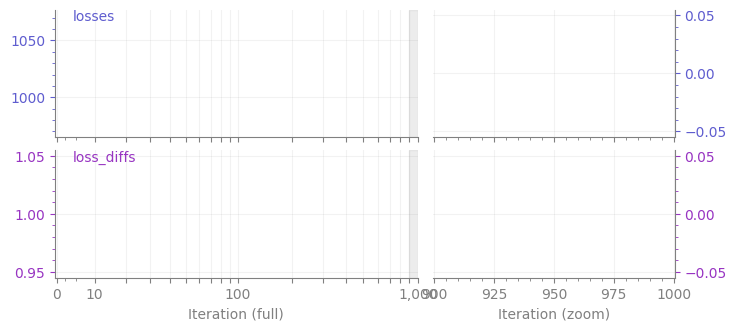

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [190]:
optmzr.plot()

In [191]:
ml, mr = split_mpo_pair(mpo_opt)

In [192]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(nan+nanj, dtype=complex64), (nan+nanj), (nan+nanj))

## 7

In [193]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0.001):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [194]:
loss_data=list()

In [195]:
total_physical_dim = 2**9

In [196]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [197]:
mpo_opt = optmzr.optimize(
    1000,
    learning_rate=0.001,
    beta1=0.05,
    beta2=0.05,
)

  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+3.333772897720 [best: +3.202516794205] : : 1001it [00:03, 303.22it/s]                                                                                                                                      


In [198]:
len(loss_data)

1

But lose loss data for some reason...?

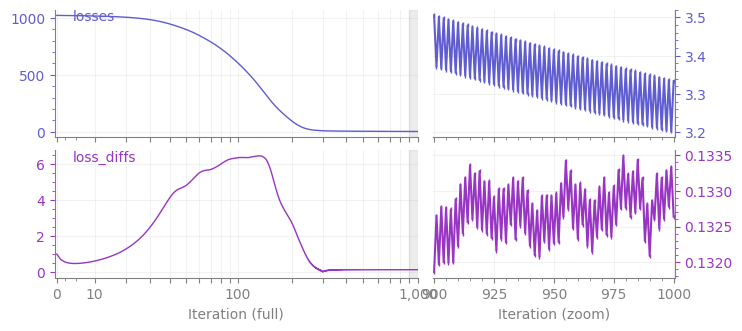

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [199]:
optmzr.plot()

In [200]:
ml, mr = split_mpo_pair(mpo_opt)

In [201]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(0.9387228-0.j, dtype=complex64),
 (1.63775634765625+1.6431302356068045e-05j),
 (0.757232666015625-1.2501361652539345e-05j))

## 8

In [203]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [204]:
loss_data=list()

In [205]:
total_physical_dim = 2**9

In [206]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 10,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [207]:
mpo_opt = optmzr.optimize(
    10000,
    learning_rate=0.0001,
    beta1=0.05,
    beta2=0.05,
)

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+9.426206588745 [best: +9.426100730896] : : 10001it [00:23, 417.96it/s]                                                                                                                                     


In [208]:
len(loss_data)

1

But lose loss data for some reason...?

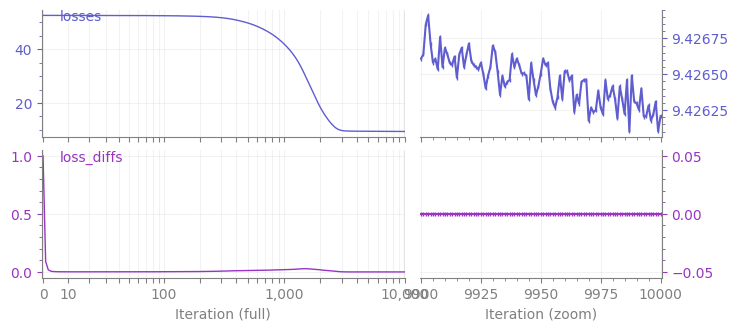

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [209]:
optmzr.plot()

In [210]:
ml, mr = split_mpo_pair(mpo_opt)

In [211]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(0.9387228-0.j, dtype=complex64),
 Array(0.05471802, dtype=float32, weak_type=True),
 Array(0.02435303, dtype=float32, weak_type=True))

## 9

In [212]:
loss_data=list()

In [213]:
total_physical_dim = 2**9

In [214]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 100,
        'losses': loss_data
    },
    autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [215]:
mpo_opt = optmzr.optimize(
    10000,
    learning_rate=0.0001,
    beta1=0.5,
    beta2=0.5,
)

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+93.874626159668 [best: +93.873588562012] : : 10001it [00:24, 413.19it/s]                                                                                                                                   


In [216]:
len(loss_data)

1

But lose loss data for some reason...?

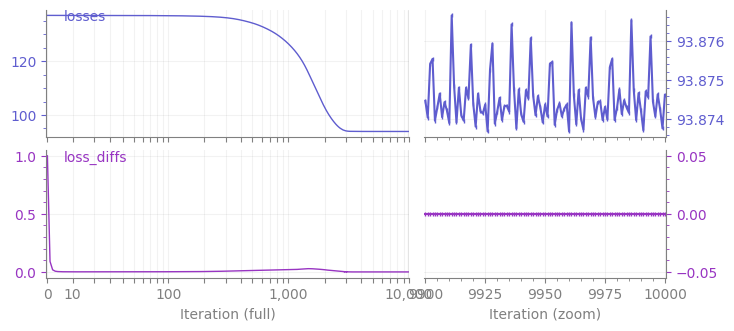

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [217]:
optmzr.plot()

In [218]:
ml, mr = split_mpo_pair(mpo_opt)

In [219]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(0.9387228-0.j, dtype=complex64),
 Array(0.00216675, dtype=float32, weak_type=True),
 Array(0.00219727, dtype=float32, weak_type=True))

Convering to the same solution everytime, so need random initialization. It's definitely better though.

# Conclusion

It's working! Need to implement random hyperparameters and initialization.